In [30]:
import os
import pandas as pd

# === Personality Data Processing ===
folder_persona = r'C:\Users\91875\Desktop\personas'
trait_cols = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]

# Load and combine all personality CSVs
persona_files = [os.path.join(folder_persona, f) for f in os.listdir(folder_persona) if f.endswith('.csv')]
persona_df = pd.concat([pd.read_csv(f) for f in persona_files], ignore_index=True)

# Clean and map Yes/No to 1/0
persona_df[trait_cols] = persona_df[trait_cols].apply(lambda col: col.astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0}))
persona_df = persona_df.dropna(subset=trait_cols, how='all')

# Aggregate per user
user_persona = persona_df.groupby("user_name")[trait_cols].mean().round(2).reset_index()

# === Bias Data Processing ===
folder_bias = r"C:\Users\91875\Desktop\biases"
bias_list = [
    "Loss Aversion", "Overconfidence", "Confirmation Bias", "Anchoring",
    "Herd Behavior", "Status Quo Bias", "Disposition Effect", "Regret Aversion",
    "Self-Attribution Bias", "Framing Effect", "Mental Accounting", "Recency Bias",
    "Affect Heuristic", "Sunk Cost Fallacy", "Present Bias", "Authority Bias"
]

bias_data = []

# Read all bias CSVs
for file in os.listdir(folder_bias):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder_bias, file))
        if 'user_name' not in df.columns or 'detected_biases' not in df.columns:
            continue
        df['detected_biases'] = df['detected_biases'].fillna("")
        for bias in bias_list:
            df[bias] = df['detected_biases'].apply(lambda x: int(bias in x))
        df = df[['user_name'] + bias_list]
        bias_data.append(df)

# Combine and group bias per user
bias_df = pd.concat(bias_data, ignore_index=True)
user_bias = bias_df.groupby("user_name")[bias_list].sum().reset_index()

# === Intersection of Users ===
common_users = set(user_persona["user_name"]) & set(user_bias["user_name"])
print(f"Total common users: {len(common_users)}")  # Should be around 325

# Filter both datasets
persona_common = user_persona[user_persona["user_name"].isin(common_users)].reset_index(drop=True)
bias_common = user_bias[user_bias["user_name"].isin(common_users)].reset_index(drop=True)

# === Merge Persona + Bias (1:1) ===
persona_bias_merged = pd.merge(persona_common, bias_common, on="user_name")

# Save the final merged dataset
persona_bias_merged.to_csv("final_persona_bias_combined.csv", index=False)
print("Final merged persona-bias file saved to 'final_persona_bias_combined.csv'")


Total common users: 326
Final merged persona-bias file saved to 'final_persona_bias_combined.csv'


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
df = pd.read_csv("final_persona_bias_combined.csv")

# Trait and bias columns
trait_cols = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]
bias_cols = [col for col in df.columns if col not in trait_cols + ["user_name"]]

# Binarize traits (for co-occurrence/frequency)
binary_traits = df[trait_cols].applymap(lambda x: 1 if x >= 0.5 else 0)



C:\Users\91875\AppData\Local\Temp\ipykernel_8172\3817837041.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_traits = df[trait_cols].applymap(lambda x: 1 if x >= 0.5 else 0)


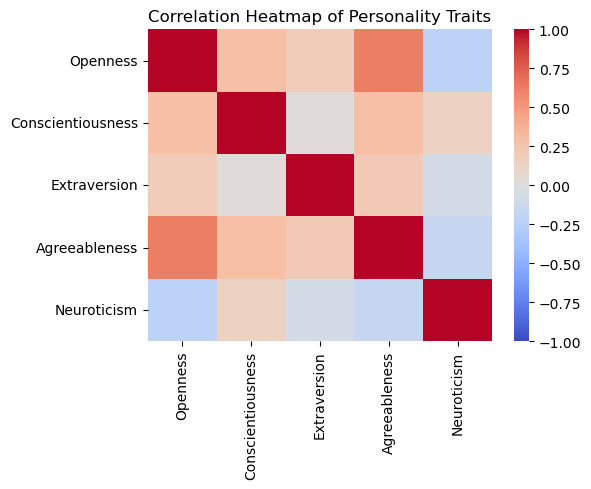

In [43]:

# Correlation heatmap of traits
plt.figure(figsize=(6, 5))
sns.heatmap(df[trait_cols].corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Personality Traits")
plt.tight_layout()
plt.show()

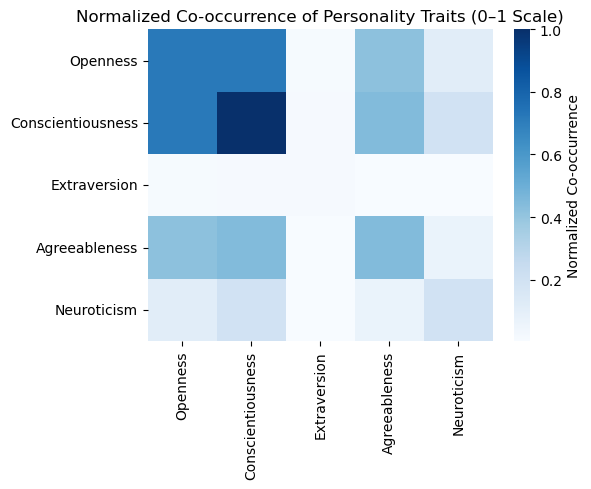

In [46]:
# Co-occurrence heatmap (normalized 0–1)
trait_co_matrix = binary_traits.T.dot(binary_traits)
trait_co_matrix_normalized = trait_co_matrix / trait_co_matrix.values.max()

plt.figure(figsize=(6, 5))
sns.heatmap(trait_co_matrix_normalized, annot=False, fmt=".2f", cmap="Blues", cbar_kws={"label": "Normalized Co-occurrence"})
plt.title("Normalized Co-occurrence of Personality Traits (0–1 Scale)")
plt.tight_layout()
plt.show()


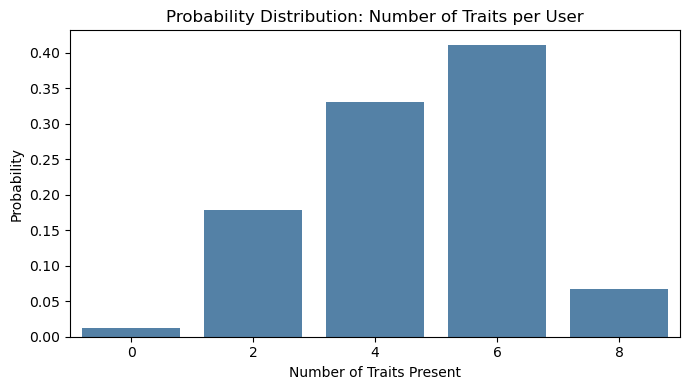

In [35]:


# Trait count distribution per user
binary_traits["trait_count"] = binary_traits.sum(axis=1)
trait_count_dist = binary_traits["trait_count"].value_counts(normalize=True).sort_index()
plt.figure(figsize=(7, 4))
sns.barplot(x=trait_count_dist.index, y=trait_count_dist.values, color="steelblue")
plt.title("Probability Distribution: Number of Traits per User")
plt.xlabel("Number of Traits Present")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

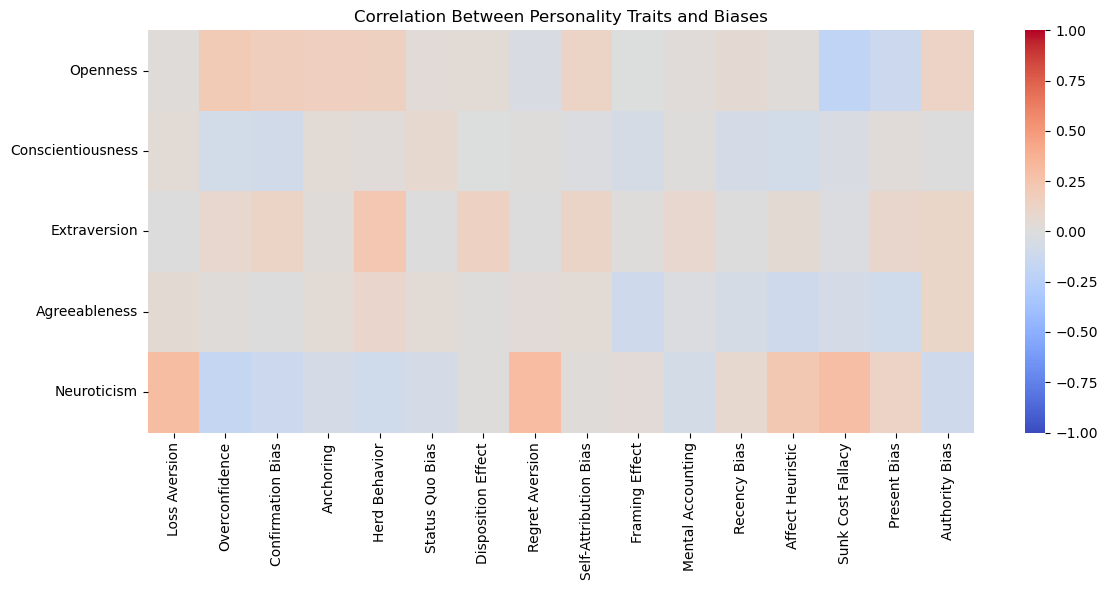

In [52]:
# Correlation heatmap between traits and biases with range -1 to 1
corr_matrix = df[trait_cols + bias_cols].corr().loc[trait_cols, bias_cols]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Between Personality Traits and Biases")
plt.tight_layout()
plt.show()


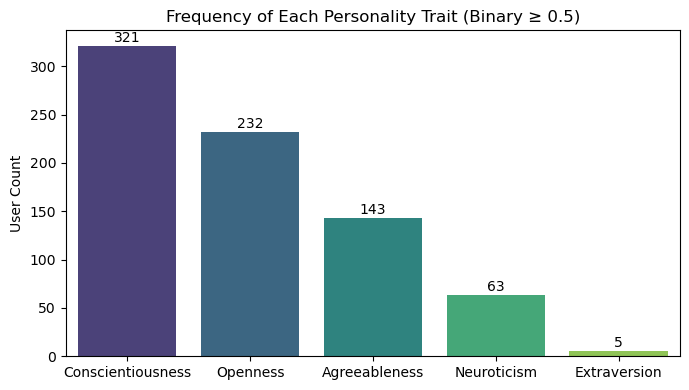

In [47]:
# Frequency of each trait with values shown on top
trait_freq = binary_traits[trait_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(7, 4))
ax = sns.barplot(x=trait_freq.index, y=trait_freq.values, palette='viridis')
plt.title("Frequency of Each Personality Trait (Binary ≥ 0.5)")
plt.ylabel("User Count")

# Add value labels on top of bars
for i, val in enumerate(trait_freq.values):
    ax.text(i, val + 1, f'{val}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


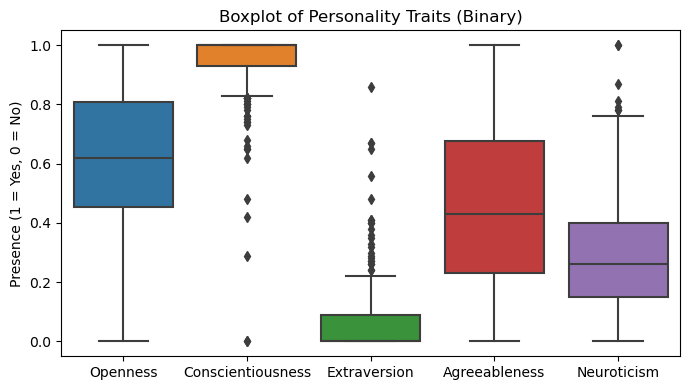

In [51]:

# === Step 2: Boxplot ===
plt.figure(figsize=(7, 4))
sns.boxplot(data=df[trait_cols])
plt.title("Boxplot of Personality Traits (Binary)")
plt.ylabel("Presence (1 = Yes, 0 = No)")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import os

processed_folder = r"C:\Users\91875\Desktop\biases"
all_found_users = set()

for fname in os.listdir(processed_folder):
    if not fname.endswith(".csv"):
        continue

    fpath = os.path.join(processed_folder, fname)

    try:
        # Try UTF-8 first, then fallback to latin1
        try:
            df = pd.read_csv(fpath, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(fpath, encoding='latin1')
            print(f"⚠️ Used fallback encoding for {fname}")

        if 'user_name' in df.columns:
            users = df['user_name'].dropna().str.strip().str.lower().unique()
            all_found_users.update(users)
        else:
            print(f"⚠️ No 'user_name' column in {fname}")

    except Exception as e:
        print(f"❌ Skipped {fname}: {e}")

# Final count
print(f"\n✅ Total unique users in all bias files: {len(all_found_users)}")

# Optional: save to CSV
pd.DataFrame(sorted(all_found_users), columns=["user_name"]).to_csv("all_users_in_bias_folder.csv", index=False)


⚠️ Used fallback encoding for 1611financial_bias_detected_output_1747_2000.csv

✅ Total unique users in all bias files: 334


In [7]:
import pandas as pd
import os

# Update these paths as needed
file_paths = [
    r"C:\Users\91875\Desktop\intern\experiment1_traits_only (1).csv",
    r"C:\Users\91875\Desktop\intern\experiment2_traits_with_keywords.csv",
    r"C:\Users\91875\Desktop\experiment3_semantic_traits (2).csv"
]

def extract_top_5_yes_no(df):
    yes_df = df[df['Loss_Aversion'].str.strip().str.lower() == 'yes']
    no_df = df[df['Loss_Aversion'].str.strip().str.lower() == 'no']

    # Prioritize by Intensity (High > Mid > Low)
    intensity_order = ['high', 'mid', 'low']
    yes_df['Intensity'] = yes_df['Intensity'].str.strip().str.lower()
    yes_sorted = pd.concat([yes_df[yes_df['Intensity'] == lvl] for lvl in intensity_order])
    yes_top5 = yes_sorted.head(5)
    no_top5 = no_df.head(5)

    return pd.concat([yes_top5, no_top5], ignore_index=True)

for idx, path in enumerate(file_paths, start=1):
    try:
        df = pd.read_csv(path, encoding='ISO-8859-1')  # fallback for special characters
        result = extract_top_5_yes_no(df)
        output_name = f"exp{idx}_new.csv"
        result.to_csv(output_name, index=False, encoding='utf-8')
        print(f"✅ Saved: {output_name} with {result.shape[0]} rows")
    except Exception as e:
        print(f"❌ Error processing {path}: {e}")


✅ Saved: exp1_new.csv with 10 rows
✅ Saved: exp2_new.csv with 10 rows
✅ Saved: exp3_new.csv with 10 rows


C:\Users\91875\AppData\Local\Temp\ipykernel_10044\4004229387.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yes_df['Intensity'] = yes_df['Intensity'].str.strip().str.lower()
C:\Users\91875\AppData\Local\Temp\ipykernel_10044\4004229387.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yes_df['Intensity'] = yes_df['Intensity'].str.strip().str.lower()
C:\Users\91875\AppData\Local\Temp\ipykernel_10044\4004229387.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [11]:
import pandas as pd

# Load all three processed CSV files
dfs = []
for i in range(1, 4):
    df = pd.read_csv(f'exp{i}_new.csv')
    dfs.append(df)

# Create a single Excel file with separate sheets for each experiment
output_excel = "/mnt/data/experiments_combined.xlsx"
with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
    for i, df in enumerate(dfs, start=1):
        df.to_excel(writer, sheet_name=f'exp{i}_new', index=False)

output_excel


OSError: Cannot save file into a non-existent directory: '\mnt\data'

In [10]:
# Install xlsxwriter module which is required for Excel export
!pip install xlsxwriter


   ---------------------------------------- 0.0/172.3 kB ? eta -:--:--
   -- ------------------------------------- 10.2/172.3 kB ? eta -:--:--
   --------- ----------------------------- 41.0/172.3 kB 388.9 kB/s eta 0:00:01
   ---------------------- --------------- 102.4/172.3 kB 837.8 kB/s eta 0:00:01
   ---------------------------------------- 172.3/172.3 kB 1.1 MB/s eta 0:00:00


In [12]:
import pandas as pd
import os

# ✅ Paths to your CSV files (update if needed)
file_paths = [
    r"C:\Users\91875\Desktop\intern\experiment1_traits_only (1).csv",
    r"C:\Users\91875\Desktop\intern\experiment2_traits_with_keywords.csv",
    r"C:\Users\91875\Desktop\experiment3_semantic_traits (2).csv"
]

# ✅ Output Excel file path
output_excel = r"C:\Users\91875\Desktop\intern\experiments_combined.xlsx"

# ✅ Function to select 5 Yes (priority High > Mid > Low) + 5 No
def extract_top_5_yes_no(df):
    df['Loss_Aversion'] = df['Loss_Aversion'].astype(str).str.strip().str.lower()
    df['Intensity'] = df['Intensity'].astype(str).str.strip().str.lower()

    yes_df = df[df['Loss_Aversion'] == 'yes']
    no_df = df[df['Loss_Aversion'] == 'no']

    yes_priority = pd.concat([
        yes_df[yes_df['Intensity'] == 'high'],
        yes_df[yes_df['Intensity'] == 'mid'],
        yes_df[yes_df['Intensity'] == 'low']
    ], ignore_index=True)

    top_yes = yes_priority.head(5)
    top_no = no_df.head(5)

    return pd.concat([top_yes, top_no], ignore_index=True)

# ✅ Create Excel file with 3 sheets
with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
    for i, path in enumerate(file_paths, start=1):
        try:
            df = pd.read_csv(path, encoding='ISO-8859-1')  # fallback encoding
            result = extract_top_5_yes_no(df)
            sheet_name = f"exp{i}_new"
            result.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"✅ Sheet '{sheet_name}' written with {result.shape[0]} rows")
        except Exception as e:
            print(f"❌ Error processing {path}: {e}")

print(f"\n✅ All sheets saved to:\n{output_excel}")


✅ Sheet 'exp1_new' written with 10 rows
✅ Sheet 'exp2_new' written with 10 rows
✅ Sheet 'exp3_new' written with 10 rows

✅ All sheets saved to:
C:\Users\91875\Desktop\intern\experiments_combined.xlsx
